# Proyek Klasifikasi Gambar : Pneumonia X-Ray Images



* Nama : Moh. Aflah Azzaky
* Email : aflahazzaki123@gmail.com
* ID Dicoding : aflahazzaky
* Dataset : https://www.kaggle.com/datasets/d4f6436b892c3daf9090ba3fafdf8d9d9a1982ed68b7277d772735498e1353af

## Install & Import Libary

In [1]:
!pip install tensorflow==2.15
# !pip install tensorflowjs

import os, shutil
import zipfile
import random
import shutil
import pathlib
import numpy as np
import pandas as pd
import cv2
import skimage
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import drive
from random import sample
from shutil import copyfile
from pathlib import Path
from tqdm.notebook import tqdm as tq
from PIL import Image
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

## Data Preparation

### Data Loading

In [2]:
!pip install kaggle

os.environ['KAGGLE_KEY'] = 'aflahazzaky'
os.environ['KAGGLE_USERNAME'] = 'bb18e594229a6d36e6251ef61baea580'

!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
!unzip pneumonia-xray-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: train/normal/IM-0435-0001-0001.jpeg  
  inflating: train/normal/IM-0435-0001.jpeg  
  inflating: train/normal/IM-0437-0001-0001.jpeg  
  inflating: train/normal/IM-0437-0001-0002.jpeg  
  inflating: train/normal/IM-0437-0001.jpeg  
  inflating: train/normal/IM-0438-0001.jpeg  
  inflating: train/normal/IM-0439-0001-0001.jpeg  
  inflating: train/normal/IM-0439-0001-0002.jpeg  
  inflating: train/normal/IM-0439-0001.jpeg  
  inflating: train/normal/IM-0440-0001.jpeg  
  inflating: train/normal/IM-0441-0001.jpeg  
  inflating: train/normal/IM-0442-0001.jpeg  
  inflating: train/normal/IM-0444-0001.jpeg  
  inflating: train/normal/IM-0445-0001.jpeg  
  inflating: train/normal/IM-0446-0001.jpeg  
  inflating: train/normal/IM-0447-0001.jpeg  
  inflating: train/normal/IM-0448-0001.jpeg  
  inflating: train/normal/IM-0449-0001.jpeg  
  inflating: train/normal/IM-0450-0001.jpeg  
  inflating: train/normal/IM-0451-0001.jpe

### Data Preprocessing

In [3]:
zip_path = 'pneumonia-xray-images.zip'

# Fungsi untuk menghitung file berdasarkan kategori
def count_file(zip_path, category):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        files = [file for file in zip_ref.namelist() if file.startswith(category)]
    return len(files)

# Menghitung jumlah file untuk setiap kategori
train_count = count_file(zip_path, 'train')
test_count = count_file(zip_path, 'test')
val_count = count_file(zip_path, 'val')

# Menampilkan hasil
print(f'Jumlah file untuk kategori "TRAIN": {train_count}')
print(f'Jumlah file untuk kategori "TEST": {test_count}')
print(f'Jumlah file untuk kategori "VAL": {val_count}')

Jumlah file untuk kategori "TRAIN": 4192
Jumlah file untuk kategori "TEST": 624
Jumlah file untuk kategori "VAL": 1040


### Dataset Checking

In [4]:
# Direktori pelatihan
train_dir = 'train'

# Direktori pengujian
test_dir = 'test'

# Direktori tujuan
combined_dir = 'dataset'

# Membuat direktori tujuan jika belum ada
os.makedirs(combined_dir, exist_ok=True)

In [5]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
  category_dir = os.path.join(train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)
    print(f'Berhasil menyalin direktori {category} ke {combined_dir}')

# Salin file dan folder dari test
for category in os.listdir(test_dir):
  category_dir = os.path.join(test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)
    print(f'Berhasil menyalin direktori {category} ke {combined_dir}')

Berhasil menyalin direktori opacity ke dataset
Berhasil menyalin direktori normal ke dataset
Berhasil menyalin direktori opacity ke dataset
Berhasil menyalin direktori normal ke dataset


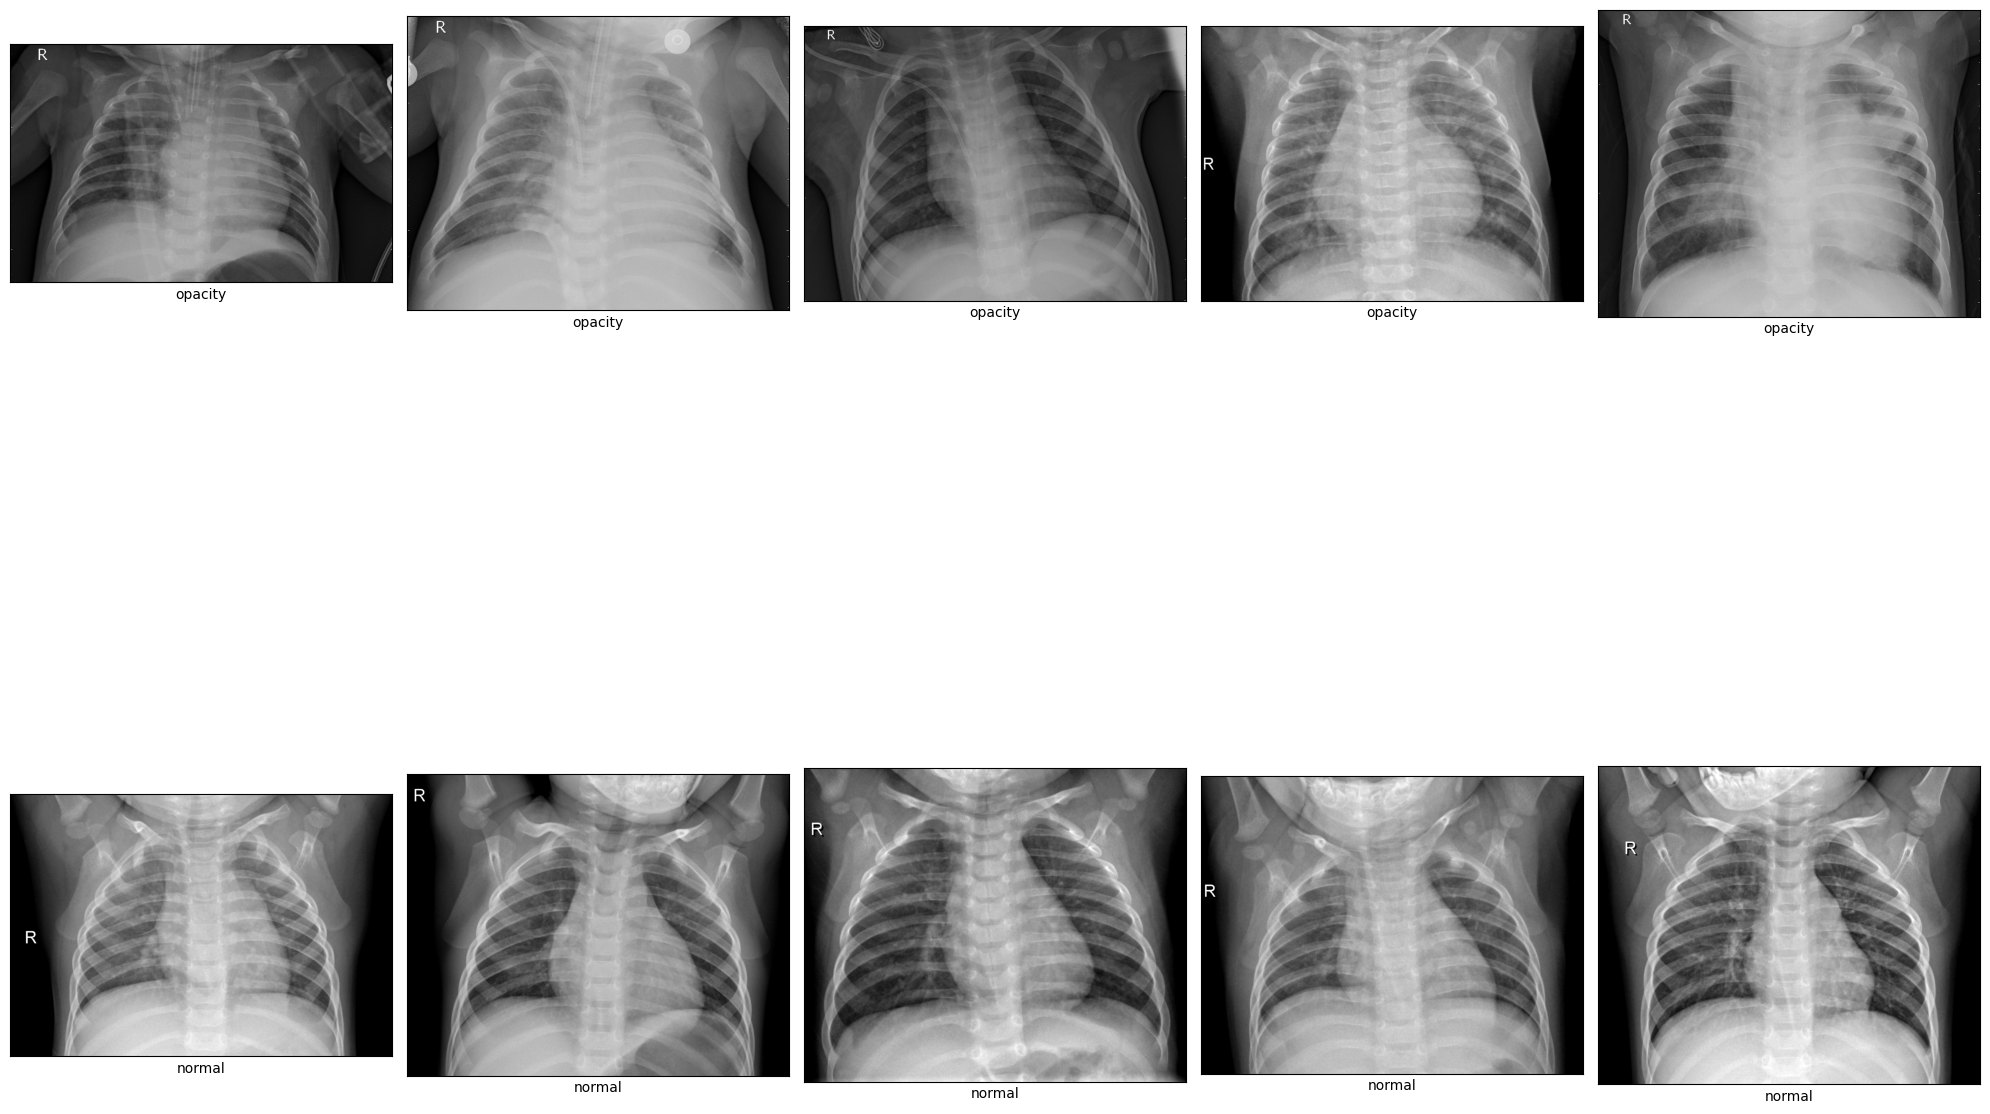

In [6]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
pneumonia_image = {}

# Tentukan path sumber train
path = '/content'
path_sub = os.path.join(path, 'dataset')
for i in os.listdir(path_sub):
  pneumonia_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = 'dataset'

fig, axs = plt.subplots(len(pneumonia_image.keys()), 5, figsize=(20, 20))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(pneumonia_image[class_name], size=5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert('L')
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

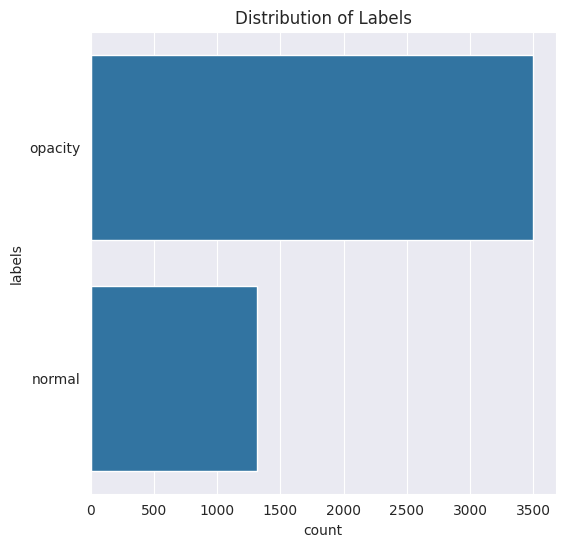

In [7]:
# Definisikan path sumber
pneumonia_path = 'dataset'

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu persatu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(pneumonia_path):
  for name in files:
    file_name.append(name)
    labels.append(os.path.basename(path))
    full_path.append(os.path.join(path, name))

distribution_train = pd.DataFrame({'path':full_path, 'file_name':file_name, 'labels':labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style('darkgrid')
plot_data = sns.countplot(Label)
plt.title('Distribution of Labels')
plt.show()

### Data Augmentation

In [8]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [9]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

pneumonia_names = ['normal']
base_path = 'dataset'

for pneumonia_name in pneumonia_names:
  images_path = os.path.join(base_path, pneumonia_name)
  augmented_path = os.path.join(base_path, pneumonia_name)
  images = [os.path.join(images_path, im) for im in os.listdir(images_path)]

  images_to_generate = 2000
  i = 1

  while i <= images_to_generate:
    image = random.choice(images)
    try:
      original_image = io.imread(image)
      transformed_image = None

      n = 0
      transformation_count = random.randint(1, len(transformations))

      while n <= transformation_count:
        key = random.choice(list(transformations))
        transformed_image = transformations[key](original_image)
        n = n + 1

      new_image_path = os.path.join(augmented_path, f"augmented_image_{i}.jpg")
      transformed_image = img_as_ubyte(transformed_image)
      cv2.imwrite(new_image_path, transformed_image)

      i = i + 1
    except ValueError as e:
      print('Could not read the', image, ':', e, 'hence skipping it.')

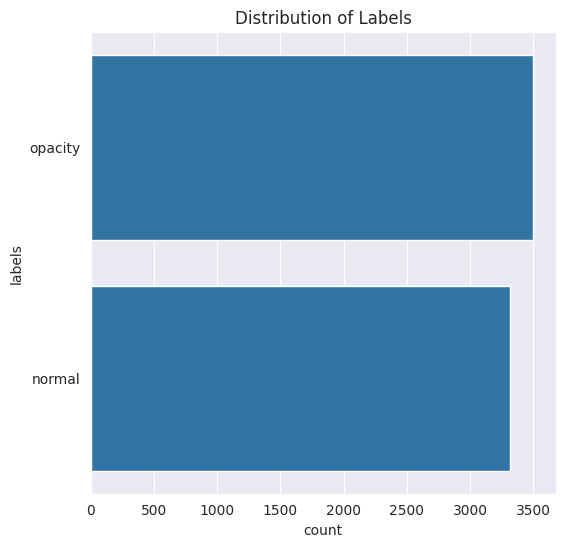

In [10]:
# Definisikan path sumber
pneumonia_path = 'dataset'

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu persatu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(pneumonia_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(os.path.basename(path))
    file_name.append(name)

distribution_train = pd.DataFrame({'path':full_path, 'file_name':file_name, 'labels':labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style('darkgrid')
plot_data = sns.countplot(Label)
plt.title('Distribution of Labels')
plt.show()

### Data Splitting

In [11]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath = 'dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(os.path.basename(path))
    file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
normal,3316
opacity,3500


In [12]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [13]:
# Menyatukan ke dalam masing-masing dataframe
df_train = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_test = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [14]:
# Gabungkan DataFrame train dan test
df_all = pd.concat([df_train, df_test], ignore_index=True)
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = 'dataset/'

# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "dataset-final/"


set    labels 
test   normal      651
       opacity     713
train  normal     2665
       opacity    2787
dtype: int64 


                                            path   labels    set
6678    dataset/opacity/person124_virus_239.jpeg  opacity   test
4862   dataset/opacity/person667_virus_1253.jpeg  opacity  train
1730    dataset/normal/NORMAL2-IM-0364-0001.jpeg   normal  train
1729  dataset/opacity/person87_bacteria_433.jpeg  opacity  train
5408     dataset/normal/augmented_image_1779.jpg   normal  train


In [15]:
for index, row in tq(df_all.iterrows()):
  # Deteksi filepath
  file_path = row['path']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])


  # Buat direktori tujuan folder
  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))


  # Tentukan tujuan file
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  # Salin file
  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

## Image Data Generator

In [16]:
# Definisikan direktori training dan test
train_dir = 'dataset-final/train'
test_dir = 'dataset-final/test'

pneumonia_name = ['normal', 'opacity']

train_paths = {pneumonia: os.path.join(train_dir, pneumonia) for pneumonia in pneumonia_name}
test_paths = {pneumonia: os.path.join(test_dir, pneumonia) for pneumonia in pneumonia_name}

for pneumonia in pneumonia_name:
  train_count = len(os.listdir(train_paths[pneumonia]))
  test_count = len(os.listdir(test_paths[pneumonia]))
  print(f'Jumlah gambar dalam {pneumonia} (train): {train_count}')
  print(f'Jumlah gambar dalam {pneumonia} (test): {test_count}')

Jumlah gambar dalam normal (train): 2665
Jumlah gambar dalam normal (test): 651
Jumlah gambar dalam opacity (train): 2787
Jumlah gambar dalam opacity (test): 713


In [17]:
# Buat objek ImageDataGenerator yang menormalkan gambar
BATCH_SIZE = 32
TARGET_SIZE = (150, 150)

datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    batch_size = BATCH_SIZE,
    target_size = TARGET_SIZE,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size = BATCH_SIZE,
    target_size = TARGET_SIZE,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle = False
)

Found 5452 images belonging to 2 classes.
Found 1364 images belonging to 2 classes.


## Modeling

In [18]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2)))

model1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2)))

model1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2)))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(2, activation='softmax'))

model1.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 32)        128       
 chNormalization)                                                
                                                        

## Evaluation and Visualization

In [19]:
count_normal = len(os.listdir(train_paths['normal']))
count_opacity = len(os.listdir(train_paths['opacity']))

# Menghitung bobot
weight0 = (1/count_normal) * (count_normal + count_opacity) / 2
weight1 = (1/count_opacity) * (count_normal + count_opacity) / 2

class_weights = {0: weight0, 1: weight1}
print('Class weights : ',class_weights)

class EarlyStoppingByAccuracy(Callback):
  def __init__(self, monitor='val_accuracy', value=0.85, verbose=0):
    super(Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    current = logs.get(self.monitor)
    if current is None:
      print(f"Warning: Early stopping requires {self.monitor} available!")
      return
    if current > self.value:
      if self.verbose > 0:
        print(f"Epoch {epoch + 1}: early stopping threshold reached: {current} > {self.value}")
      self.model.stop_training = True

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.85) and (logs.get('val_accuracy') > 0.85)):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 85%!")
callbacks1 = myCallback()

# Definisi callback
callbacks = [
    EarlyStoppingByAccuracy(monitor='val_accuracy', value=0.85, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    # ModelCheckpoint('best_model.keras', save_best_only=True)
]

EPOCHS = 30
BATCH_SIZE = 32
STEPS_PER_EPOCH = 150
VALIDATION_STEPS = 35

# Fitting
history1 = model1.fit(
    train_generator,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = test_generator,
    # steps_per_epoch= STEPS_PER_EPOCH,
    # validation_steps= VALIDATION_STEPS,
    # callbacks = [callbacks1],
    callbacks = callbacks,
    class_weight = class_weights
)

# Evaluasi model
test_loss, test_acc = model1.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

Class weights :  {0: 1.022889305816135, 1: 0.9781126659490492}
Epoch 1/30
171/171 [==============================] - 382s 2s/step - loss: 0.9282 - accuracy: 0.8008 - val_loss: 4.9162 - val_accuracy: 0.5227
Epoch 2/30
171/171 [==============================] - 383s 2s/step - loss: 0.3073 - accuracy: 0.9092 - val_loss: 3.2628 - val_accuracy: 0.5293
Epoch 3/30
43/43 [==============================] - 35s 806ms/step - loss: 0.5043 - accuracy: 0.8519
Test Loss: 0.5043337345123291
Test Accuracy: 0.8519061803817749


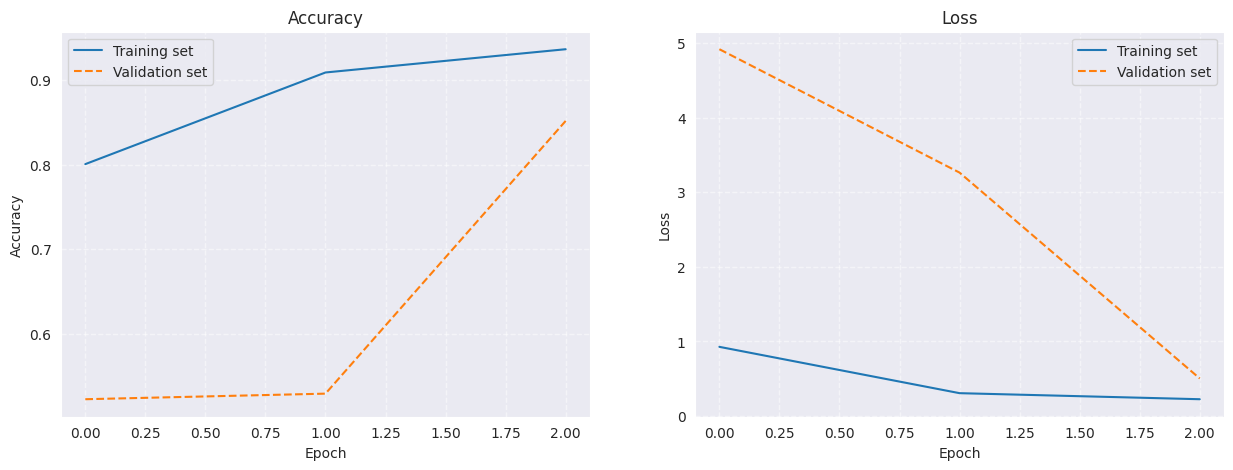

In [20]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

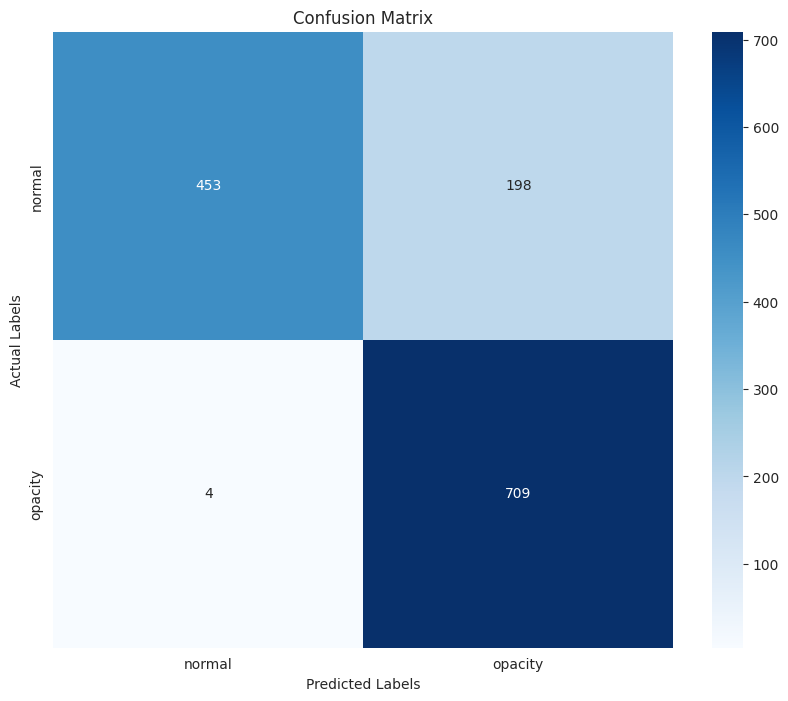



              precision    recall  f1-score   support

      normal     0.9912    0.6959    0.8177       651
     opacity     0.7817    0.9944    0.8753       713

    accuracy                         0.8519      1364
   macro avg     0.8865    0.8451    0.8465      1364
weighted avg     0.8817    0.8519    0.8478      1364



In [21]:
test_generator.reset()
pred=model1.predict(test_generator, verbose=0)
predicted_class_indices=np.argmax(pred,axis=1)
class_names = ['normal','opacity']

cm = confusion_matrix(test_generator.classes, predicted_class_indices, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=predicted_class_indices,target_names =['normal','opacity'], digits=4))

## Model Conversion

In [ ]:
# Save the model
model1.save('model.h5')
model1.save('model.keras')

# Convert the model to TensorFlow.js format
!tensorflowjs_converter --input_format keras model.h5 tfjs_model

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

### Saved Model

In [24]:
# Asumsikan 'model' adalah model yang sudah dilatih
model1.save('model.h5')
model1.save('model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### TFJS Model

In [27]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.5 MB/s eta 0:00:00
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
    

2024-08-09 10:31:03.424347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 10:31:03.463264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 10:31:03.463342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 10:31:04.872831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### TFLite Model

In [22]:
# import tensorflow as tf
export_dir = 'saved_model/'
tf.saved_model.save(model1, export_dir)

converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

# import tensorflow as tf
# model = tf.keras.models.load_model('model.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# open("model.tflite", "wb").write(tflite_model)

5617388

### Export Model

In [25]:
!pip freeze > requirements.txt

In [28]:
!zip -r tfjs_model.zip tfjs_model
# !zip -r saved_model.zip saved_model

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of2.bin (deflated 8%)
  adding: tfjs_model/group1-shard1of2.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 87%)


## Inference (Optional)